# Introduction 

This builds a basic VAMPnets model without the deeptime module. The resulting output will still be put in a deptime VAMP model to compare to the deeptime version. 

In [2]:
from copy import deepcopy
from pathlib import Path
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.parameter import Parameter
import torch.nn.functional as F


from addict import Dict

from deeptime.util.types import to_dataset
from deeptime.decomposition import VAMP
from deeptime.decomposition.deep import VAMPNet, vampnet_loss, VAMPNetModel

## Functions

In [3]:
assert torch.cuda.is_available(), "Need a GPU with CUDA" 
torch.backends.cudnn.benchmark = True

In [4]:
data_dir = "/home/rob/online_vampnets/data"
coordinates_path = Path(data_dir).joinpath('alanine-dipeptide-3x250ns-heavy-atom-positions.npz')
dihedrals_path = Path(data_dir).joinpath('alanine-dipeptide-3x250ns-backbone-dihedrals.npz')

In [5]:
with np.load(coordinates_path.open('rb')) as fh:
    data = [fh[f"arr_{i}"].astype(np.float32) for i in range(3)]

with np.load(dihedrals_path.open('rb')) as fh:
    dihedral = [fh[f"arr_{i}"] for i in range(3)]

dataset = to_dataset(data=data, lagtime=1)


In [80]:
# def create_lobes(input_dim, device, output_dim): 
#     lobe = nn.Sequential(
#         nn.BatchNorm1d(input_dim), 
#         nn.Linear(input_dim, 30), nn.ELU(),
#         nn.Linear(30, 100), nn.ELU(),
#         nn.Linear(100, 100), nn.ELU(),
#         nn.Linear(100, 100), nn.ELU(),
#         nn.Linear(100, 100), nn.ELU(),
#         nn.Linear(100, 100), nn.ELU(),
#         nn.Linear(100, 100), nn.ELU(),
#         nn.Linear(100, 30), nn.ELU(),
#         nn.Linear(30, output_dim),
#         nn.Softmax(dim=1)  # obtain fuzzy probability distribution over output states
#     )
    
#     lobe_timelagged = lobe.to(device=device)
#     lobe = lobe.to(device=device)
#     return (lobe, lobe_timelagged)


# def deeptime_model(device, train_data, val_data, lobes, config):

#     estimator = VAMPNet(lobe=lobes[0], lobe_timelagged=lobes[1], 
#                         learning_rate=config.lr, device=device, 
#                         optimizer=config.optimizer, 
#                         score_mode=config.score_mode, 
#                         epsilon=config.score_eps)
#     loader_train = DataLoader(train_data, batch_size=10000, shuffle=True)
#     loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False) 
#     model = estimator.fit(loader_train, n_epochs=config.n_epochs,
#                     validation_loader=loader_val).fetch_model()
#     return estimator, model 

# def its(model, config):
#     lagtimes = np.arange(1, 201, dtype=np.int32)
#     timescales = []
#     for lag in lagtimes:
#         ts = VAMP(lagtime=lag, observable_transform=model).fit(data).fetch_model().timescales(k=config.output_dim-1)
#         timescales.append(ts)
#     return lagtimes, timescales


class CelerityVAMPNet(nn.Module):
    def __init__(self, 
                input_dim: int, 
                output_dim: int, 
                n_hidden_layers: int, 
                hidden_layer_width: int,
                use_cuda: bool = True, 
                batch_size: int = 2, 
                b: float = 0.99, 
                n: float = 0.01, # Weight update learning rate 
                s: float = 0.1
                ):
        super(CelerityVAMPNet, self).__init__()

        # Setup device
        if torch.cuda.is_available() and use_cuda:
            print("Using CUDA :]")

        self.device = torch.device(
            "cuda:0" if torch.cuda.is_available() and use_cuda else "cpu")

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.batch_size = batch_size
        assert self.batch_size > 1, "Covariance estimators need two samples at least"
        # Setup layers
        hidden_layers = []
        output_layers = []
        self.n_hidden_layers = n_hidden_layers
        hidden_layers.append(nn.Linear(input_dim, hidden_layer_width))
        for i in range(n_hidden_layers-1): 
            hidden_layers.append(
                nn.Linear(hidden_layer_width, hidden_layer_width)
            )
        for i in range(n_hidden_layers): 
            output_layers.append(nn.Linear(hidden_layer_width, output_dim)) 

        self.hidden_t_0 = nn.ModuleList(hidden_layers).to(self.device)
        self.output_t_0 = nn.ModuleList(output_layers).to(self.device)
        

        # Other training parameters
        self.b = Parameter(torch.tensor(
            b), requires_grad=False).to(self.device)
        self.n = Parameter(torch.tensor(
            n), requires_grad=False).to(self.device)
        self.s = Parameter(torch.tensor(
            s), requires_grad=False).to(self.device)

        self.alpha = Parameter(torch.Tensor(self.n_hidden_layers).fill_(1 / (self.n_hidden_layers + 1)),
                               requires_grad=False).to(
            self.device)

        # Output accumulators
        self.loss_array = []
        self.alpha_array = []

    def partial_forward(self, hidden_module: nn.Module, output_module: nn.Module, x: np.ndarray) -> List[torch.Tensor]: 
        hidden_connections = []
        X = torch.from_numpy(x).float().to(self.device)
        X = torch.reshape(X, (self.batch_size, -1))
        
        # push forward through main network
        hidden_connections.append(F.elu(hidden_module[0](X)))
        for i in range(1, self.n_hidden_layers): 
            hidden_connections.append(F.elu(hidden_connections[i-1]))

        # push through outputs
        predictions_per_layer = []
        for i in range(self.n_hidden_layers): 
            tmp = output_module[i](hidden_connections[i])
            predictions_per_layer.append(F.softmax(tmp, dim=1))
        return predictions_per_layer 

    def zero_grad(self):

        for i in range(self.n_hidden_layers):
            # print('zeroing layer: ', i)
            self.hidden_t_0[i].zero_grad()
            self.output_t_0[i].zero_grad()

            # print("\t", self.hidden_t_0[i].weight.grad) #.data.fill_(0)
            # print("\t", self.hidden_t_0[i].bias.grad) #.data.fill_(0)
            # print("\t", self.output_t_0[i].weight.grad) #.data.fill_(0)
            # print("\t", self.output_t_0[i].bias.grad) #.data.fill_(0)

    def forward(self, x: Tuple[np.ndarray]) -> Tuple[List[torch.Tensor]]:
        x_0, x_tau = x[0], x[1]
        pred_0_per_layer = self.partial_forward(self.hidden_t_0, self.output_t_0, x_0)
        pred_tau_per_layer = self.partial_forward(self.hidden_t_0, self.output_t_0, x_tau)
        return (pred_0_per_layer, pred_tau_per_layer)

    def update_weights(self, X): 
        predictions_per_layer = self.forward(X)
        losses_per_layer = []
   
        for pred_0, pred_tau in zip(*predictions_per_layer):
            print(torch.sum(pred_0))
            loss = vampnet_loss(pred_0, pred_tau, method='VAMP2', epsilon=1e-6, mode='regularize') 
            losses_per_layer.append(loss)

        w = [None] * len(losses_per_layer)
        b = [None] * len(losses_per_layer)
        
        with torch.no_grad():   
            for i in range(len(losses_per_layer)):

                print('updated layer = ', i)
                losses_per_layer[i].backward(retain_graph=True)             
                self.output_t_0[i].weight.data -= self.n * \
                                                   self.alpha[i] * self.output_t_0[i].weight.grad.data
                self.output_t_0[i].bias.data -= self.n * \
                                                 self.alpha[i] * self.output_t_0[i].bias.grad.data
                for k in range(self.n_hidden_layers):
                    print('checking gradients ', k, ' = ',  torch.sum(self.hidden_t_0[k].weight.grad))

                for j in range(i + 1):
                    if w[j] is None:
                        w[j] = self.alpha[i] * self.hidden_t_0[j].weight.grad.data
                        b[j] = self.alpha[i] * self.hidden_t_0[j].bias.grad.data
                    else:
                        w[j] += self.alpha[i] * self.hidden_t_0[j].weight.grad.data
                        b[j] += self.alpha[i] * self.hidden_t_0[j].bias.grad.data

                self.zero_grad()

            for i in range(len(losses_per_layer)):
                self.hidden_t_0[i].weight.data -= self.n * w[i]
                self.hidden_t_0[i].bias.data -= self.n * b[i]

            for i in range(len(losses_per_layer)):
                self.alpha[i] *= torch.pow(self.b, losses_per_layer[i])
                self.alpha[i] = torch.max(
                    self.alpha[i], self.s / self.n_hidden_layers)
        
        z_t = torch.sum(self.alpha)
        self.alpha = Parameter(
            self.alpha / z_t, requires_grad=False).to(self.device)

    def partial_fit(self, X): 
        self.update_weights(X)
        

def score_batch(device, model, x, config):
    x0, xt = x[0].to(device), x[1].to(device)
    output = model((x0, xt))
    loss = vampnet_loss(output[0], output[1], method=config.score_method, 
                        epsilon=config.score_eps, mode=config.score_mode)
    return loss

def train_batch(device, model, optimizer, x, config):
    optimizer.zero_grad()
    loss = score_batch(device, model, x, config)
    loss.backward()
    optimizer.step()
    return loss

def train_epoch(device, model, optimizer, data_loader, config, step=0):
    scores = []
    model.train()
    for batch_t_0, batch_t_tau in data_loader: 
        loss = train_batch(device, model, optimizer, (batch_t_0, batch_t_tau), config)
        step += 1
        scores.append((step, -loss.item()))
    return scores

def validate(device, model, data_loader, config, step): 
    model.eval()
    losses = []
    for i, (vbatch_t_0, vbatch_t_tau) in enumerate(data_loader):
        with torch.no_grad():
            val_loss = score_batch(device, model, (vbatch_t_0, vbatch_t_tau), config)
            losses.append(val_loss)
        mean_score = -torch.mean(torch.stack(losses)).item()   
    return [(step, mean_score)]

In [81]:
model = CelerityVAMPNet(input_dim=30, output_dim=6, 
                        n_hidden_layers=5, 
                        hidden_layer_width=100, 
                        batch_size=100)

model.partial_fit((data[0][:100], data[0][1:101]))        


Using CUDA :]
tensor(100., device='cuda:0', grad_fn=<SumBackward0>)
tensor(100., device='cuda:0', grad_fn=<SumBackward0>)
tensor(100., device='cuda:0', grad_fn=<SumBackward0>)
tensor(100., device='cuda:0', grad_fn=<SumBackward0>)
tensor(100., device='cuda:0', grad_fn=<SumBackward0>)
updated layer =  0
checking gradients  0  =  tensor(0.4672, device='cuda:0')


TypeError: sum(): argument 'input' (position 1) must be Tensor, not NoneType

## Load data

## Configuration

In [6]:
config = Dict(lag_time = 1, 
              validation_split = 0.3, 
              input_dim = int(data[0].shape[1]), 
              output_dim = 6, 
              lr = 5e-4, 
              n_epochs = 1, 
              optimizer=torch.optim.Adam, 
              score_method='VAMP2', 
              score_mode='regularize', 
              score_eps=1e-6)

## Split data

In [7]:
n_val = int(len(dataset)*config.validation_split)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])

## Train model

In [54]:

# Setup model
device = torch.device("cuda")
model = CelerityVAMPNet(input_dim=config.input_dim, output_dim=config.output_dim, stationary=True)
model = model.to(device)

# Optimizer
optimizer = config.optimizer(model.parameters(), lr=config.lr)

# create data loaders
loader_train = DataLoader(train_data, batch_size=10000, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False) 

# accumulators
init_step = 0
train_scores = []
valid_scores = []

# fit
for epoch in range(config.n_epochs):
    print(epoch, end=', ')
    train_scores.extend(train_epoch(device, model, optimizer, loader_train, config, init_step))
    init_step = train_scores[-1][0]

    valid_scores.extend(validate(device, model, loader_val, config, init_step))

train_scores = np.array(train_scores)
valid_scores = np.array(valid_scores)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 

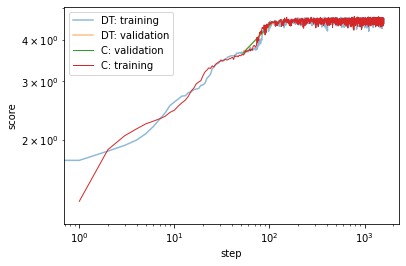

In [56]:
plt.plot(valid_scores[:, 0], valid_scores[:, 1], label='C: validation',lw=1)
plt.plot(train_scores[:, 0], train_scores[:, 1], label='C: training',lw=1)
plt.xlabel('step')
plt.ylabel('score')
plt.xscale('log')
plt.legend();



In [57]:
ct_mod = VAMPNetModel(model.t_0, model.t_tau, device=device)
ct_its = its(ct_mod, config)
dt_its = its(dt_mod, config)

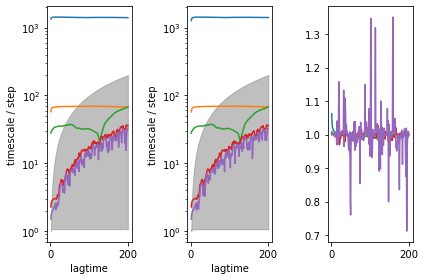

In [58]:
f, axes = plt.subplots(1, 3)
itss = [dt_its, ct_its]
for i in range(2):
    ax = axes[i]
    its = itss[i]
    ax.semilogy(its[0], its[1])
    ax.set_xlabel('lagtime')
    ax.set_ylabel('timescale / step')
    ax.fill_between(its[0], ax.get_ylim()[0]*np.ones(len(its[1])), its[0], alpha=0.5, color='grey')

axes[-1].plot(itss[0][0], np.array(itss[0][1])/np.array(itss[1][1]))
axes[-1].set_ylim()
plt.tight_layout()